<a href="https://www.kaggle.com/code/roshk01/image-training-with-efficientnetv2-mobilnetv2?scriptVersionId=235472864" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tf_keras as tfk
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-04-22 15:51:45.403563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745337105.685580      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745337105.769391      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset'

In [3]:
cv2.imread('/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png').shape

(83, 226, 3)

In [4]:
img = cv2.imread('/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png')

(-0.5, 225.5, 82.5, -0.5)

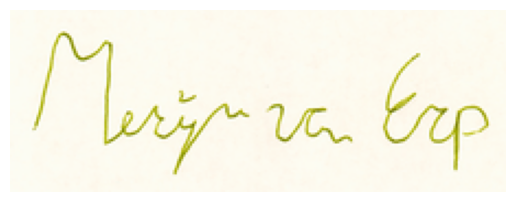

In [5]:
plt.imshow(np.array(img))
plt.axis('off')

# images resize to model define size

In [6]:
x,y = [], []

image_shape = (256, 256)

#get dataset name from dataset  Directory
for dataset_name in os.listdir(data_dir):
    dataset_path = os.path.join(data_dir,dataset_name)

    if os.path.isdir(dataset_path):
        #get category path in each dataset
        for label, category in enumerate(['forge','real']):
            category_path = os.path.join(dataset_path,category)

            if not os.path.isdir(category_path):
                continue

            #get image path
            for img_name in tqdm(os.listdir(category_path)):   
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)

                if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                
                img_resize = img.resize(image_shape)   # img resize
                x.append(img_resize)
                y.append(label)   # 0 for forge 1 for real 
            

100%|██████████| 150/150 [00:04<00:00, 33.33it/s]


In [7]:
len(x)

630

In [8]:
np.array(x[0]).shape

(256, 256)

In [9]:
x_np = []
for img in x:
    img = img.resize((256, 256)).convert("RGB")  # Force consistent size and 3 channels
    img_array = np.array(img) / 255.0            # Normalize
    x_np.append(img_array)

x_np = np.array(x_np)

In [10]:
y_np = np.array(y)

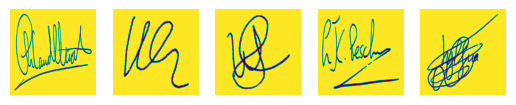

In [11]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x[i])
    plt.axis('off')

plt.show()

In [12]:
label_dict = {
    1:'real',
    0:'forge'
}

Text(0.5, 1.0, 'real')

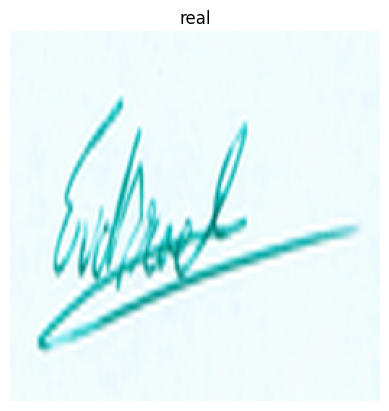

In [13]:
plt.imshow(np.array(x[200]))
plt.axis('off')
plt.title(label_dict[y[200]])

# Test & Train Data Division

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_np,y_np, random_state=42, test_size = 0.2)

In [15]:
len(x_train)

504

In [16]:
len(x_test)

126

# model Setup for Training data

In [17]:
import keras_cv
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0"
)

backbone.summary()

2025-04-22 15:52:30.063717: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "efficient_net_v2_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_conv (Conv2D)                   │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_bn (BatchNormalization)         │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_activation (Activation)         │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_ (FusedMBConvBlock)          │ (None, None, None, 16)      │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2a_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2b_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3a_ (FusedMBConvBlock)          │ (None, None, None, 48)      │          43,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3b_ (FusedMBConvBlock)          │ (None, None, None, 48)      │          93,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4a_ (MBConvBlock)               │ (None, None, None, 96)      │          36,108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4b_ (MBConvBlock)               │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4c_ (MBConvBlock)               │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5a_ (MBConvBlock)               │ (None, None, None, 112)     │         158,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5b_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5c_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5d_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5e_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block6a_ (MBConvBlock)               │ (None, None, None, 192)     │         254,812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block6b_ (MBConvBlock)               │ (None, None, None, 192)     │         574,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block6c_ (MBConvBlock)               │ (None, None, None, 192)     │         574,512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [18]:
backbone.trainable = False

inputs = keras.Input(shape=(256,256,3))
x_in= backbone(inputs)
x_in = layers.GlobalAveragePooling2D()(x_in)
x_in = layers.Dense(128,activation='relu')(x_in)
outputs = layers.Dense(2,activation='softmax')(x_in)

model = keras.Model(inputs = inputs,outputs=outputs)

model.compile(
    loss= "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
datagen.fit(x_train)
# images = tf.ones((1, 256, 256, 3))
model.fit(datagen.flow(x_np,y_np),epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5434 - loss: 0.6931
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6234 - loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5730 - loss: 0.6929
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5614 - loss: 0.6929
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5793 - loss: 0.6927
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5649 - loss: 0.6927
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5544 - loss: 0.6927
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5974 - loss: 0.6923
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6020 - loss: 0.6921
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5676 - loss: 0.6924


# accuracy in mobilenetv2


In [19]:
image_shape = (128,128)
classifier = tfk.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2", input_shape=image_shape+(3,))
])

In [20]:
x_np_mobil = []
for img in x:
    img = img.resize((128, 128)).convert("RGB")  # Force consistent size and 3 channels
    img_array = np.array(img) / 255.0            # Normalize
    x_np_mobil.append(img_array)

x_np_mobil = np.array(x_np_mobil)

In [21]:
y_np_mobil = np.array(y)

In [22]:
from sklearn.model_selection import train_test_split
x_train_1,x_test_1,y_train_1,y_test_1 = train_test_split(x_np_mobil,y_np_mobil, random_state=42, test_size = 0.2)

In [23]:
mobil = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
image_shape = (128,128)
Pretrain_model_without_top_layer = tfk.Sequential([hub.KerasLayer(mobil,input_shape=image_shape+(3,),trainable=False)])

In [24]:
modelmobil = tfk.Sequential([
    Pretrain_model_without_top_layer,
    tfk.layers.Dense(2)
])

modelmobil.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 1694493 (6.46 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [25]:
modelmobil.compile(
    optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
)

In [26]:
modelmobil.fit(x_np_mobil,y_np_mobil,epochs=10)

Epoch 1/10
20/20 [==============================] - 10s 65ms/step - loss: 0.8073 - accuracy: 0.5952
Epoch 2/10
20/20 [==============================] - 1s 63ms/step - loss: 0.6531 - accuracy: 0.6714
Epoch 3/10
20/20 [==============================] - 1s 64ms/step - loss: 0.5367 - accuracy: 0.7365
Epoch 4/10
20/20 [==============================] - 1s 63ms/step - loss: 0.4862 - accuracy: 0.7825
Epoch 5/10
20/20 [==============================] - 1s 65ms/step - loss: 0.4488 - accuracy: 0.8016
Epoch 6/10
20/20 [==============================] - 1s 64ms/step - loss: 0.4164 - accuracy: 0.8206
Epoch 7/10
20/20 [==============================] - 1s 65ms/step - loss: 0.3759 - accuracy: 0.8635
Epoch 8/10
20/20 [==============================] - 1s 67ms/step - loss: 0.3520 - accuracy: 0.8762
Epoch 9/10
20/20 [==============================] - 1s 65ms/step - loss: 0.3427 - accuracy: 0.8683
Epoch 10/10
20/20 [==============================] - 1s 65ms/step - loss: 0.3447 - accuracy: 0.8667


In [27]:
pickle.dump(model,open('model_efficientnetv2','wb'))
pickle.dump(modelmobil,open('model_mobilnet','wb'))

In [28]:
md = pickle.load(open('model_efficientnetv2','rb'))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 492 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
from sklearn.metrics import accuracy_score
y_pred_probs_effic = md.predict(x_test)
y_pred_probs_mobil = modelmobil.predict(x_test_1)
y_pred_1 = np.argmax(y_pred_probs_effic, axis=1) if y_pred_probs_effic.shape[1] > 1 else (y_pred_probs_effic > 0.5).astype("int32")
y_pred_2 = np.argmax(y_pred_probs_mobil, axis=1) if y_pred_probs_mobil.shape[1] > 1 else (y_pred_probs_mobil > 0.5).astype("int32")

acc1 = accuracy_score(y_test, y_pred_1)
acc2 = accuracy_score(y_test, y_pred_2)
print('*************************************************')
print('*************************************************')
print('Accuracy score in efficientnetv2: ', acc1)
print('Accuracy score in mobilnetv2: ', acc2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
4/4 [==============================] - 1s 66ms/step
*************************************************
*************************************************
Accuracy score in efficientnetv2:  0.6031746031746031
Accuracy score in mobilnetv2:  0.8571428571428571
